In [10]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns  
from model.model import MultiViewGAT

In [11]:
def load_model(ckpt_path, in_dims):
    ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
    args = ckpt["args"]

    model = MultiViewGAT(
        in_dims=in_dims,
        enc_dim=args["enc_dim"],
        hidden=args["hidden"],
        fusion_dim=args["fusion_dim"],
        heads=args["heads"],
        dropout=args["dropout"]
    )
    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    print(f"Loaded model from {ckpt_path}")
    return model, args


def compute_saliency(model, xs, es, ews):
    for x in xs:
        x.requires_grad_(True)
    logits = model(xs, es, ews)
    logit = logits.squeeze()

    model.zero_grad()
    logit.backward(retain_graph=True)
    
    saliency = [x.grad.abs().detach().cpu().numpy()[0] for x in xs]
    return saliency

Loaded model from c:\Users\pmx12\OneDrive\Desktop\Research\PD_Dectection\pd-detection\checkpoints\best_epoch_42.pth
Analyzing sample index 5, label=1


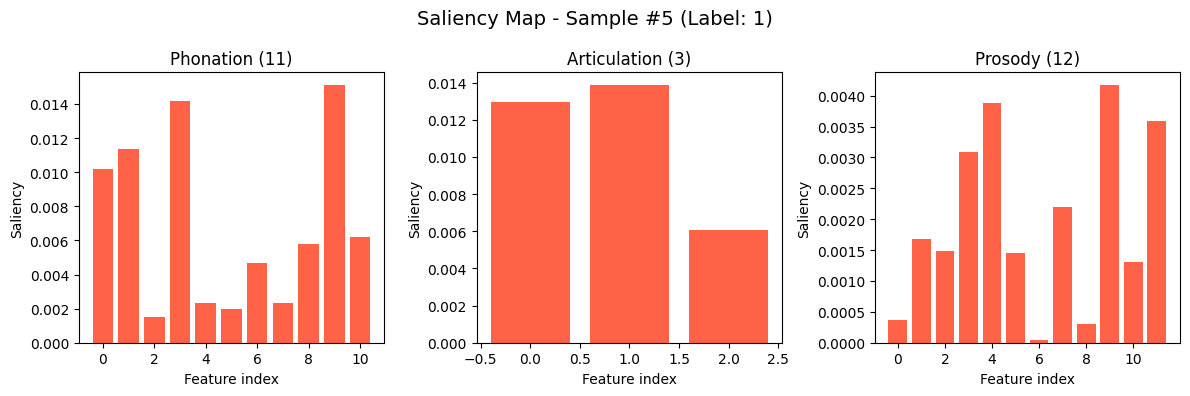

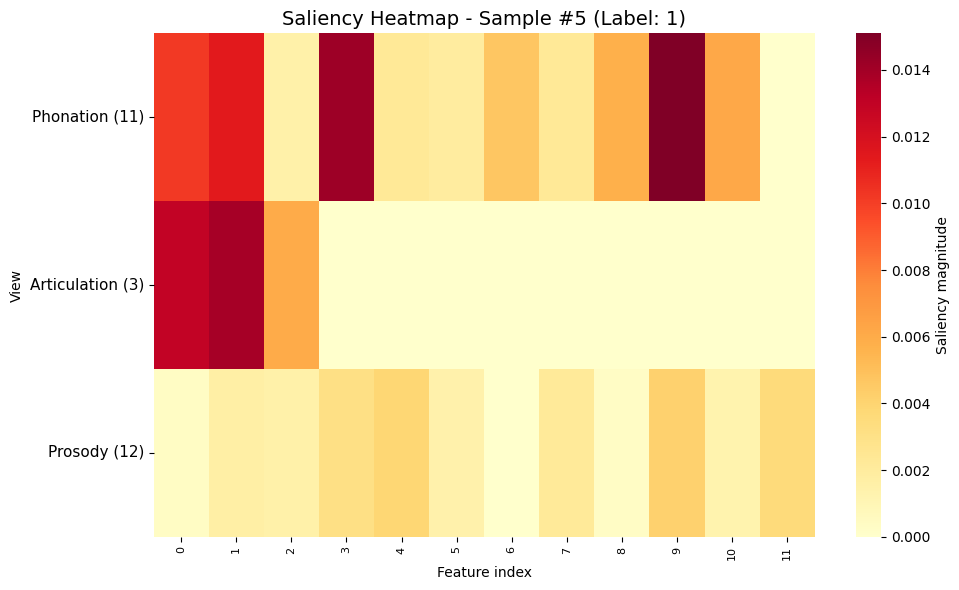


Phonation (11) - Top contributing features:
  • Feature 9: importance = 0.0151
  • Feature 3: importance = 0.0142
  • Feature 1: importance = 0.0113

Articulation (3) - Top contributing features:
  • Feature 1: importance = 0.0139
  • Feature 0: importance = 0.0130
  • Feature 2: importance = 0.0061

Prosody (12) - Top contributing features:
  • Feature 9: importance = 0.0042
  • Feature 4: importance = 0.0039
  • Feature 11: importance = 0.0036


In [12]:
ckpt_dir = os.path.join(os.getcwd(), "checkpoints")
ckpt_path = os.path.join(ckpt_dir, "best_epoch_42.pth")
if not os.path.exists(ckpt_path):
    raise FileNotFoundError(f"Checkpoint not found at {ckpt_path}")

in_dims = [11, 3, 12]
model, args = load_model(ckpt_path, in_dims)

base = args["data_dir"]
y = np.load(os.path.join(base, "labels_class.npy")).astype(np.float32)
X1 = np.load(os.path.join(base, "view1_phonation.npy"))
X2 = np.load(os.path.join(base, "view2_articulation.npy"))
X3 = np.load(os.path.join(base, "view3_prosody.npy"))

i = 5
print(f"Analyzing sample index {i}, label={int(y[i])}")

xs = [torch.tensor(X1[i:i+1], dtype=torch.float32),
        torch.tensor(X2[i:i+1], dtype=torch.float32),
        torch.tensor(X3[i:i+1], dtype=torch.float32)]

edge_index = torch.tensor([[0], [0]], dtype=torch.long)
edge_attr = torch.tensor([[1.0]], dtype=torch.float)
es = [edge_index]*3
ews = [edge_attr]*3

saliency = compute_saliency(model, xs, es, ews)

views = ["Phonation (11)", "Articulation (3)", "Prosody (12)"]
plt.figure(figsize=(12, 4))
for j, s in enumerate(saliency):
    plt.subplot(1, 3, j + 1)
    plt.bar(np.arange(len(s)), s, color="tomato")
    plt.title(f"{views[j]}")
    plt.xlabel("Feature index")
    plt.ylabel("Saliency")
plt.suptitle(f"Saliency Map - Sample #{i} (Label: {int(y[i])})", fontsize=14)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))

max_len = max(len(s) for s in saliency)

saliency_padded = np.zeros((len(saliency), max_len))
for v_idx, s in enumerate(saliency):
    saliency_padded[v_idx, :len(s)] = s

ax = sns.heatmap(
    saliency_padded,
    cmap="YlOrRd", 
    cbar_kws={"label": "Saliency magnitude"},
    annot=False
)

ax.set_yticks(np.arange(len(views)) + 0.5)
ax.set_yticklabels(views, rotation=0, fontsize=11)
ax.set_xticks(np.arange(max_len) + 0.5)
ax.set_xticklabels(np.arange(max_len), rotation=90, fontsize=8)
plt.title(f"Saliency Heatmap - Sample #{i} (Label: {int(y[i])})", fontsize=14)
plt.xlabel("Feature index")
plt.ylabel("View")
plt.tight_layout()
plt.show()


for name, s in zip(views, saliency):
    top_idx = np.argsort(-s)[:3] 
    print(f"\n{name} - Top contributing features:")
    for k in top_idx:
        print(f"  • Feature {k}: importance = {s[k]:.4f}")